## Trabalho de Tópicos em Observação da Terra

In [6]:
suppressMessages(library(tidyverse)) # Manipulação e limpeza dos dados
suppressMessages(library(lubridate)) # Manipulação de datas
suppressMessages(library(janitor)) # Limpeza de atributos
suppressMessages(library(scales)) # Manipulação de datas
suppressMessages(library(kohonen)) # Criação de Mapas Auto-organizaveis de Kohonen
suppressMessages(library(psych)) # Gráficos de correlação entre atributos
suppressMessages(library(cowplot)) # Temas de gráficos

set.seed(123)

theme_set(theme_bw())

#### Importação dos dados

In [2]:
load("~/R/topicos_obs/data/timeseries_final_select_20190301_20191116.RData")

#### Visualização dos dados


In [30]:
tail(timeseries_forest_select, 2)

longitude,latitude,start_date,end_date,label,cube,time_series
-51.08541,-0.006683549,2019-03-01,2019-11-16,permanent_crop,MOD13Q1,"17961.0000, 17977.0000, 17993.0000, 18009.0000, 18025.0000, 18041.0000, 18057.0000, 18073.0000, 18089.0000, 18105.0000, 18121.0000, 18137.0000, 18153.0000, 18169.0000, 0.3926, 0.2946, 0.1873, 0.5926, 0.5966, 0.4951, 0.5833, 0.4641, 0.4363, 0.4937, 0.4135, 0.3490, 0.4169, 0.3064, 0.2777, 0.2365, 0.1381, 0.3772, 0.4027, 0.3902, 0.3475, 0.3397, 0.2744, 0.3164, 0.2371, 0.1997, 0.2621, 0.1997"
-47.86406,-0.954175644,2019-03-01,2019-11-16,permanent_crop,MOD13Q1,"17961.0000, 17977.0000, 17993.0000, 18009.0000, 18025.0000, 18041.0000, 18057.0000, 18073.0000, 18089.0000, 18105.0000, 18121.0000, 18137.0000, 18153.0000, 18169.0000, 0.6164, 0.1210, 0.8156, 0.9115, 0.7110, 0.8096, 0.9149, 0.8053, 0.8133, 0.8344, 0.8025, 0.7883, 0.8084, 0.7423, 0.5653, 0.1042, 0.6030, 0.5390, 0.5206, 0.5973, 0.7359, 0.5241, 0.4595, 0.6251, 0.6415, 0.6025, 0.5954, 0.5478"


#### Definição das funções auxiliares

In [69]:
#' @title Adição de novos modelos do SOM
#' @name add_row_som
#' @author Felipe Carvalho, \email{felipe.carvalho@@inpe.br}
#' 
#' @description 
#'
#' @param som_df
#' @param som_model
#' @param class 
#'
#' @return 
add_row_som <- function(som_df, som_model_list, class = NULL){
    for(index in 1:nrow(som_model_list)){
        som_df <- som_df %>% dplyr::add_row(quantisation_error = c(as.vector(som_model_list[index,]$som[[1]]$changes)),
                                            iterations = c(1:length(som_model_list[index,]$som[[1]]$changes)),
                                            grid = c(paste0(som_model_list[index,]$som[[1]]$grid$xdim, "x", som_model_list[index,]$som[[1]]$grid$ydim)),
                                            mode = som_model_list[index,]$mode,
                                            error_min = min(som_model_list[index,]$som[[1]]$changes[2:nrow(som_model_list[index,]$som[[1]]$changes)]))
  }
  return(som_df)
} 

- #### Gráfico erro de quantização

In [127]:
#'@title quantisation_plot 
#'@description Gráfico do erro de quantização e erro topográfico
#'@author Felipe Carvalho
#'
#'@param datainfo_som Tibble com as informações da rede
#'@param type_model Modelo no qual os parâmetros foram definidos
#'@param levels_grid Topologia das redes treinadas
#'
#'@return Gráfico do erro de quantização e topográfico
quantisation_plot <- function(datainfo_som, levels_grid = c("3x3", "9x9", "12x12")){
  
  datainfo_som %>%
    dplyr::mutate(grid = factor(grid, levels = levels_grid),
                  mode = factor(mode, levels=c("online", "batch"))) %>%
    ggplot(aes(x = iterations, y = quantisation_error)) + 
    geom_line() + 
    facet_grid(mode ~ grid) + 
    labs(x = "Épocas",
         y = "Distância entre a unidade mais próxima",
         title="Erro de quantização por topologia e modo de aprendizado")  + 
    geom_hline(aes(yintercept=error_min), linetype="dashed", color = "black") + 
    geom_text(aes(x = 2500,
                  y = error_min+0.003,
                  label = paste("min distance:",round(error_min, 7)),
                  fontface = "italic"),
              check_overlap = TRUE,
              show.legend = FALSE,
              colour="black",
              size = 4) +
    background_grid(minor = 'none') + 
    theme_bw() + 
    panel_border() + 
    theme(
      plot.title = element_text(hjust= 0.5,
                                margin = margin(b = 7)))
}

- #### Gráfico u-matrix

In [95]:
#'@name umatrix_plot 
#'@description Gráfico com as distâncias de cada neurônio e sua vizinha (u-matrix)
#'
#'@author Felipe Carvalho
#'
#'@param object_som Rede SOM do pacote Kohonen
#'@param title Título do gráfico
#'
#'@return Gráfico umatrix
umatrix_plot <- function(list_som_model, title = ""){
    
    for(som_model in list_som_model){
        
        plot(som_model,
             type="dist.neighbours",
             main = title,
             shape = "straight",
             codeRendering = "segments",
             keepMargins=TRUE,
         whatmap = "dist.neighbours",
         border = "black",
         heatkeywidth = .5) 
    }  
}

- #### Gráfico heatmap

In [90]:
#'@name heatmap_plot 
#'@description Gráfico heatmap de cada atributo do conjunto de dados
#'
#'@author Felipe Carvalho
#'
#'@param object_som Rede SOM do pacote Kohonen
#'@param grid_col Grid para mapear os atributos do conjunto de dados
#'
#'@return Gráfico heatmap
heatmap_plot <- function(object_som, grid_col = c(1, 3)){
  par(mfcol = grid_col)
  
  for(col_i in 1:ncol(object_som$data[[1]])){
    plot(object_som, 
         type="property",
         property = kohonen::getCodes(object_som)[,col_i],
         main = colnames(kohonen::getCodes(object_som))[col_i],
         shape = "straight",
         codeRendering = "segments",
         keepMargins=TRUE,
         whatmap = "dist.neighbours",
         border = "black",
         heatkeywidth = .5)  
  }
}

- #### Gráfico Hitmap

In [91]:
#'@name heatmap_plot 
#'@description Gráfico heatmap de cada atributo do conjunto de dados
#'
#'@author Felipe Carvalho
#'
#'@param object_som Rede SOM do pacote Kohonen
#'@param grid_col Grid para mapear os atributos do conjunto de dados
#'
#'@return Gráfico heatmap
hitmap_plot <- function(list_som_model, grid_som = c(1, 3), title = ""){
  par(mfcol = grid_som)
  for(som_model in list_som_model){
    plot(som_model, type="count", main=title,
       shape = "straight",
       codeRendering = "segments",
       keepMargins=TRUE,
       whatmap = "dist.neighbours",
       border = "black",
       heatkeywidth = .5)
  }
}

- #### Gráfico ggsom

In [110]:
#' @title aesthetics data of som object
#' @name ggsom_aes
#' @author  Felipe Carvalho, \email{lipecaso@@gmail.com} 
#' @references `Kohonen`package (https://CRAN.R-project.org/package=kohonen) and
#' `sits` package (https://CRAN.R-project.org/package=sits)
#'
#' @description Function to join categorical classes and mapping each neuron of SOM 
#' 
#' @param model_som object of self-organising maps (SOMs) - Kohonen package
#' @param class categorical attribute with dataset classes
#' @return Model data that is used in plots
#'
#' @export
ggsom_aes <- function(model_som, class) {
  
  assertthat::assert_that(is.kohonen(model_som))
  
  # Creating a data frame from the SOMs object
  model_som_values <-
    data.table::data.table(model_som$data[[1]],
                           unit.class = model_som$unit.classif,
                           class,
                           id = (1:nrow(model_som$data[[1]]))) %>%
    .[,sum:=.(.N), by="unit.class"]
  
  # Creating a data frame from the SOMs object of grid points
  model_som_pts <-
    data.table::data.table(model_som$grid$pts,
                           unit.class = 1:nrow(model_som$grid$pts))
  
  model_som_values <- model_som_pts[model_som_values, on = 'unit.class']
  
  return(model_som_values)
  
}

# Função auxiliar
is.kohonen <- function(data) inherits(data, "kohonen")

#' @title Função para obter a pureza de cada neurônio da rede SOM
#' @name get_entropy
#' @author Felipe Carvalho, \email{felipe.carvalho@@inpe.br}
#' 
#' @import entropy 
#'
#' @description Cálculo da entropia utilizando o método de máxima verossimilhança
#'
#' @param ggsom_gathered
#' @return Conjunto de dados com o atributo de pureza adicionado em formato de tibble
get_entropy <- function(ggsom_gathered){
  sum_values <- ggsom_gathered %>%
    dplyr::select(x,y, reference, id, sum) %>%
    dplyr::group_by(x,y,reference) %>%
    dplyr::summarise(a = n()/length(unique(ggsom_gathered$atributo))) %>%
    tidyr::spread(reference, a) %>%
    tidyr::gather(classe, valores, -x, -y) %>%
    dplyr::mutate(valores = replace_na(valores,0),
                  soma = sum(valores)) %>%
    tidyr::spread(classe, valores)
  
  
  entropy <- sum_values %>% dplyr::select(everything()) %>%
    tidyr::gather(classe, valores, -x, -y, -soma) %>%
    dplyr::group_by(x, y) %>%
    dplyr::mutate(entropy = entropy::entropy(valores, method = "ML", unit = "log2")) %>%
    tidyr::spread(classe, valores) %>%
    dplyr::select(x, y, entropy) %>%
    dplyr::right_join(ggsom_gathered, by=c("x","y"))
  
  return(entropy)
}

#### Gráfico de coordenadas paralelas dos dados

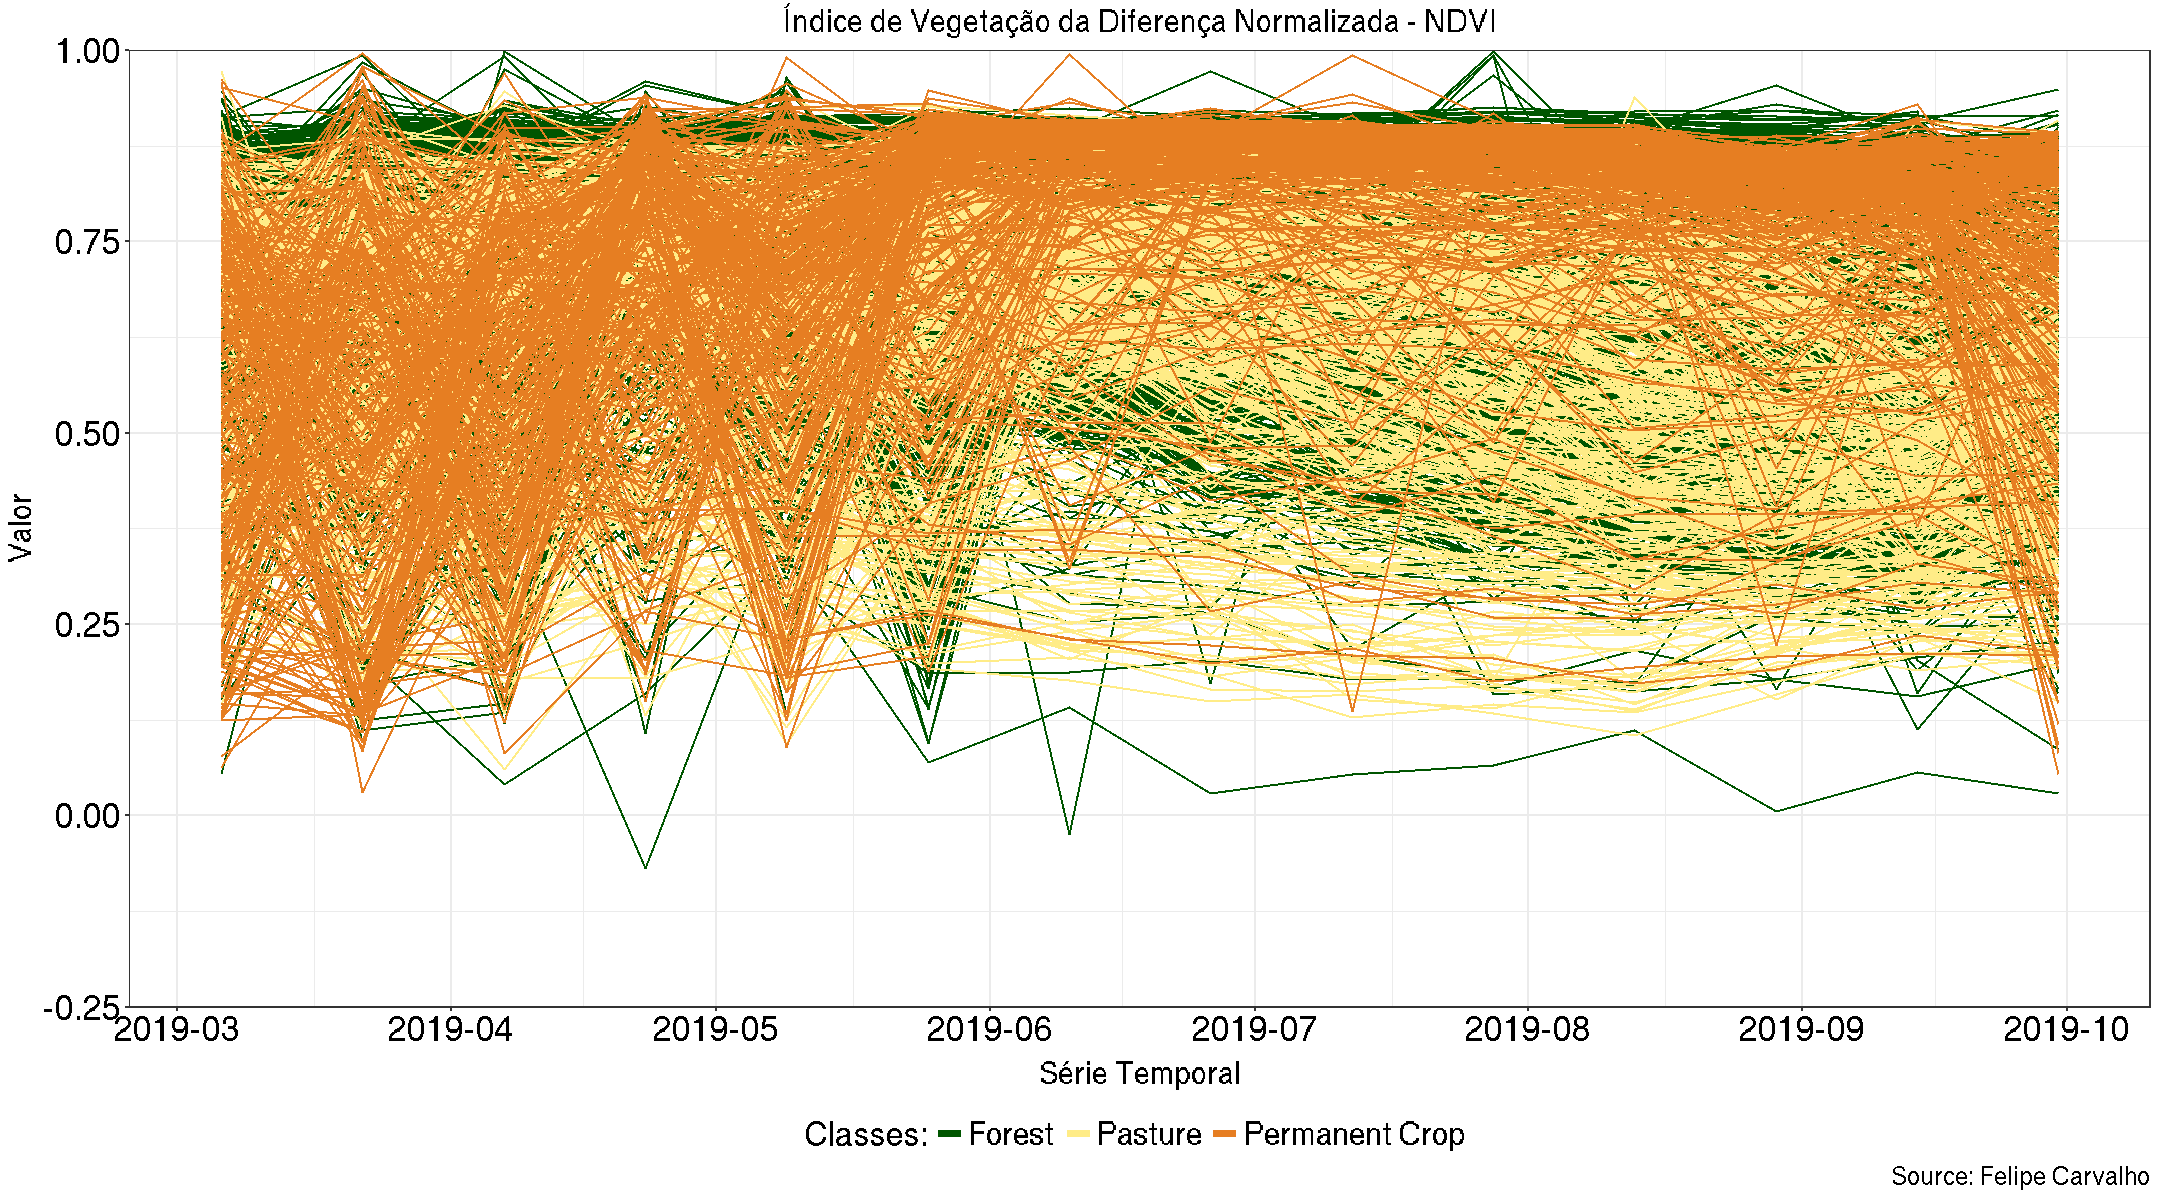

In [34]:
options(repr.plot.width=18, repr.plot.height=10)


timeseries_forest_ndvi <- timeseries_forest_select %>% 
                dplyr::mutate(id = 1:nrow(.)) %>% 
                tidyr::unnest(time_series) %>% 
                dplyr::select(-evi)

ggplot(timeseries_forest_ndvi, aes(x=Index, y= ndvi, group=id, colour = as.factor(label))) +
  geom_line(size=0.55) +
  labs(title="Índice de Vegetação da Diferença Normalizada - NDVI",
       caption="Source: Felipe Carvalho",
       y = expression("Valor"),
       x="Série Temporal") +
  scale_x_date(labels = date_format("%Y-%m"),
               breaks='1 month') +
  theme(
    plot.title = element_text(size = 18,
                              hjust= 0.5,
                              margin = margin(b = 7)),
    strip.background = element_blank(),
    panel.spacing = unit(0.6, "lines"),
    axis.text.x = element_text(color = "black",
                               size  = 21),
    axis.text.y = element_text(size = 21,
                               color="black"),
    axis.title.x = element_text(margin = margin(t = 7),
                                size=18),
    axis.title.y = element_text(size = 18),
    legend.position="bottom",
    legend.key.size = unit(1.2, "lines"),
    legend.spacing.x = unit(0.10, "cm"),
    legend.text = element_text(size = 19),
    legend.title = element_text(size = 20),
    plot.caption = element_text(size = 15, color="black"))+
  guides(colour = guide_legend(nrow = 1,
                               override.aes = list(size = 2)))+
  scale_y_continuous(limits  = c(-0.25,1),
                     breaks = seq(-0.25,1,0.25),
                     expand = c(0,0)) +
  scale_color_manual(name = "Classes: ",
                     labels = c("Forest",
                                "Pasture",
                                "Permanent Crop"),
                     values = c("#005500",
                                "#ffec87",
                                "#e67e22")) 

#### Gráfico de coordenadas paralelas por grupo

In [50]:
# Quantidade de amostras por classe
dados_count <- timeseries_forest_select %>%
    dplyr::group_by(label) %>%
    dplyr::count() %>%
    dplyr::ungroup() %>% 
    dplyr::left_join(timeseries_forest_select, by="label") %>%
    dplyr::mutate(id = 1:nrow(.))

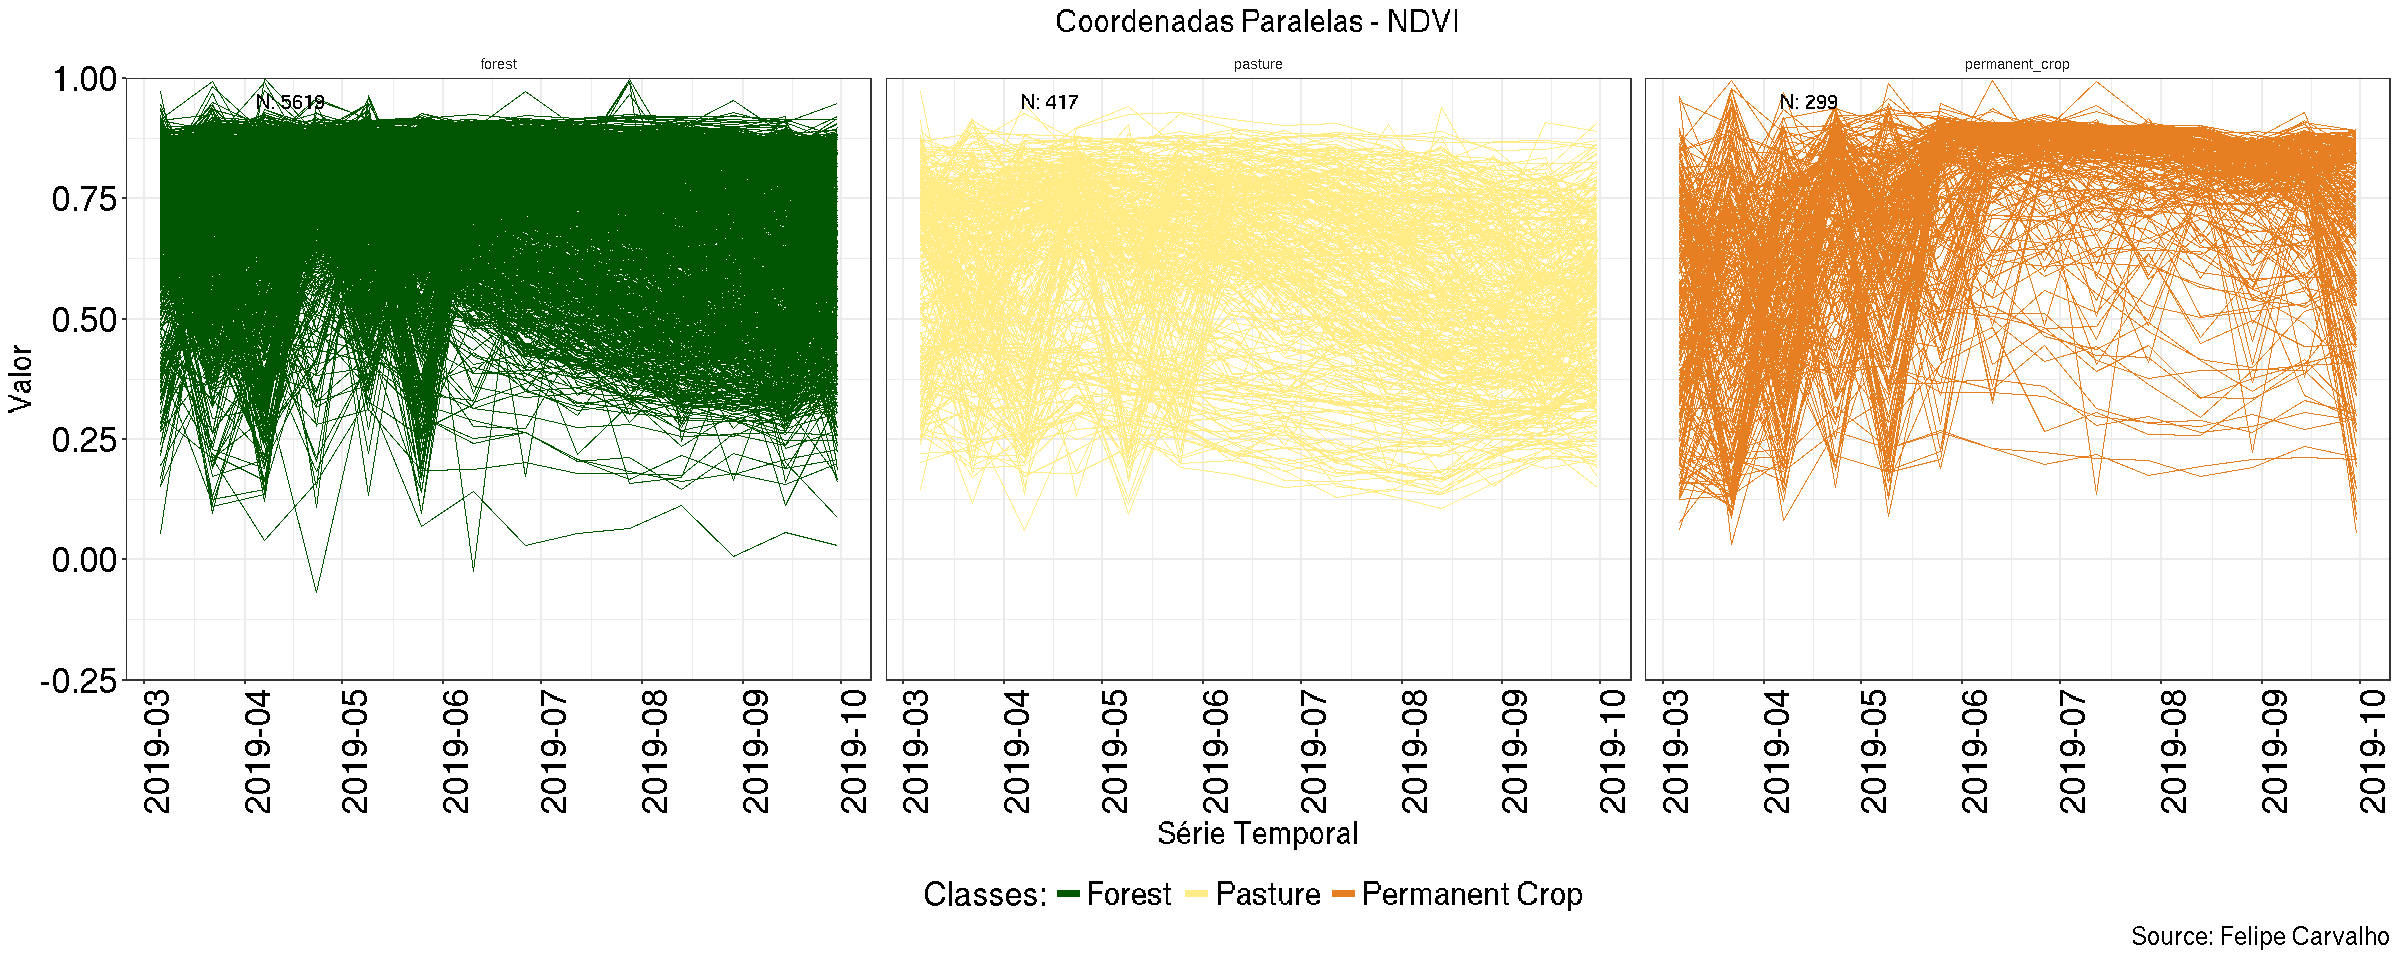

In [57]:
options(repr.plot.width=20, repr.plot.height=8)

dados_count %>%
    tidyr::unnest(cols = c(time_series)) %>% 
ggplot(aes(x=Index,y= ndvi, group=id, colour = label)) +
  geom_line(size = 0.4) +
  labs(title="Coordenadas Paralelas - NDVI",
       caption="Source: Felipe Carvalho",
       y = expression("Valor"),
       x="Série Temporal") +
  scale_x_date(labels = date_format("%Y-%m"),
               breaks='1 month') +
  facet_wrap(vars(label)) +
  theme(
    plot.title = element_text(size = 18,
                              hjust= 0.5,
                              margin = margin(b = 7)),
    strip.background = element_blank(),
    panel.spacing = unit(0.6, "lines"),
    axis.text.x = element_text(color = "black",
                               size  = 21,
                              angle = 90),
    axis.text.y = element_text(size = 21,
                               color="black"),
    axis.title.x = element_text(margin = margin(t = 7),
                                size=18),
    axis.title.y = element_text(size = 18),
    legend.position="bottom",
    legend.key.size = unit(1.2, "lines"),
    legend.spacing.x = unit(0.10, "cm"),
    legend.text = element_text(size = 19),
    legend.title = element_text(size = 20),
    plot.caption = element_text(size = 15, color="black"))+
  guides(colour = guide_legend(nrow = 1,
                               override.aes = list(size = 2)))+
  scale_y_continuous(limits  = c(-0.25,1),
                     breaks = seq(-0.25,1,0.25),
                     expand = c(0,0)) +
   scale_color_manual(name = "Classes: ",
                     labels = c("Forest",
                                "Pasture",
                                "Permanent Crop"),
                     values = c("#005500",
                                "#ffec87",
                                "#e67e22")) +
geom_text(aes(
    y = 0.95,
    x = as.Date("2019-04-15", "%Y-%m-%d"),
    label = paste("N:", n)), check_overlap = TRUE,
    show.legend = FALSE,
    colour="black",
    size = 4.5)

#### Transformação do conjunto de dados *long* para *wide* 

In [58]:
wide_dataset <- timeseries_forest_select$time_series %>%
  purrr::map(function(ts){
    as.data.frame(t(unlist(ts[-1])))
  }) %>% data.table::rbindlist()

dados_wide <- data.table::data.table("id" = 1:nrow(timeseries_forest_select),
                                     "reference" = timeseries_forest_select$label,
                                     cbind(wide_dataset)) %>%
  tibble::as_tibble(.name_repair = "minimal") %>%
  dplyr::select(id,
         reference,
         ndvi1:ndvi14) %>%
  dplyr::filter_at(vars(ndvi1:ndvi14), all_vars(. <=1))

In [59]:
head(dados_wide)

id,reference,ndvi1,ndvi2,ndvi3,ndvi4,ndvi5,ndvi6,ndvi7,ndvi8,ndvi9,ndvi10,ndvi11,ndvi12,ndvi13,ndvi14
1,forest,0.6698,0.6357,0.6487,0.6278,0.6096,0.5993,0.5561,0.4478,0.3941,0.4092,0.2744,0.4531,0.3275,0.4565
2,forest,0.6698,0.6357,0.6487,0.6278,0.6096,0.5993,0.5561,0.4478,0.3941,0.4092,0.2744,0.4531,0.3275,0.4565
3,forest,0.6698,0.6357,0.6487,0.6278,0.6096,0.5993,0.5561,0.4478,0.3941,0.4092,0.2744,0.4531,0.3275,0.4565
4,forest,0.7223,0.6357,0.7036,0.7206,0.8160,0.7721,0.7472,0.6032,0.6171,0.7752,0.4402,0.7208,0.5439,0.7027
5,forest,0.6698,0.6357,0.6487,0.6278,0.6096,0.5993,0.5561,0.4478,0.3941,0.4092,0.2744,0.4531,0.3275,0.4565
6,forest,0.6698,0.6357,0.6487,0.6278,0.6096,0.5993,0.5561,0.4478,0.3941,0.4092,0.2744,0.4531,0.3275,0.4565


## Treino da rede SOM 

In [60]:
# Seleção dos valores de cada banda
ndvi_band <- dados_wide %>% dplyr::select(ndvi1:ndvi14) %>% as.matrix() %>% unname()

#### Definição das grids de treinamento

In [61]:
# Criação de um grid 3x3, retangular com a função de vizinhança gaussiana
grid_10_10 <- kohonen::somgrid(xdim = 10,
                             ydim = 10,
                             neighbourhood.fct = "gaussian",
                             topo = "rectangular")

# Criação de um grid 9x9, retangular e com a função de vizinhança gaussiana
grid_15_15 <- kohonen::somgrid(xdim = 15,
                               ydim = 15,
                               neighbourhood.fct = "gaussian",
                               topo = "rectangular")

# Criação de um grid 12x12, retangular e com a função de vizinhança gaussiana
grid_20_20 <- kohonen::somgrid(xdim = 20,
                               ydim = 20,
                               neighbourhood.fct = "gaussian",
                               topo = "rectangular")


#### Treino do modelo SOM 10x10

In [120]:
#'@description Treino da rede SOM 10x10
#'
#'@param grid referente a topologia da rede
#'@param mode Modo de aprendizado da rede (online ou batch)
#'@param cores Quantidade de cores para paralelização durante a fase de agrupamento
#'@param rlen Quantidade de iterações durante o agrupamento
#'@param alpha Vetor de duas posições, referente a taxa de aprendizado e o decaimento, respectivamente.
#'@param radius Raio de vizinhaça em relação a quantidade total de neurônios da rede
model_som_online_10_10 <- kohonen::som(X = ndvi_band,
                                           grid = grid_10_10,
                                           mode = "online",
                                           cores = 2,
                                           rlen = 5000,
                                           alpha = c(0.05, 0.01),
                                           radius = quantile(10*10, 2/3))

model_som_batch_10_10 <- kohonen::som(X = ndvi_band,
                                           grid = grid_10_10,
                                           mode = "batch",
                                           cores = 2,
                                           rlen = 5000,
                                           alpha = c(0.05, 0.01),
                                           radius = quantile(10*10, 2/3))


In [123]:
# Criação de um tibble com as informações da rede SOM
model_df <- tibble::tibble(quantisation_error = c(as.vector(model_som_online_10_10$changes)),
                         iterations = c(1:length(model_som_online_10_10$changes)),
                         grid = c("10x10"),
                         mode = c("online"),
                         error_min = min(model_som_online_10_10$changes[2:nrow(model_som_online_10_10$changes)]))

#### Treino do modelo SOM 15x15

In [121]:
#'@description Treino da rede SOM 15x15
#'
#'@param grid referente a topologia da rede
#'@param mode Modo de aprendizado da rede (online ou batch)
#'@param cores Quantidade de cores para paralelização durante a fase de agrupamento
#'@param rlen Quantidade de iterações durante o agrupamento
#'@param alpha Vetor de duas posições, referente a taxa de aprendizado e o decaimento, respectivamente.
#'@param radius Raio de vizinhaça em relação a quantidade total de neurônios da rede
model_som_online_15_15 <- kohonen::som(X = ndvi_band,
                                           grid = grid_15_15,
                                           mode = "online",
                                           cores = 2,
                                           rlen = 5000,
                                           alpha = c(0.05, 0.01),
                                           radius = quantile(15*15, 2/3))

model_som_batch_15_15 <- kohonen::som(X = ndvi_band,
                                           grid = grid_15_15,
                                           mode = "batch",
                                           cores = 2,
                                           rlen = 5000,
                                           alpha = c(0.05, 0.01),
                                           radius = quantile(15*15, 2/3))

#### Treino do modelo SOM 20x20

In [122]:
#'@description Treino da rede SOM 15x15
#'
#'@param grid referente a topologia da rede
#'@param mode Modo de aprendizado da rede (online ou batch)
#'@param cores Quantidade de cores para paralelização durante a fase de agrupamento
#'@param rlen Quantidade de iterações durante o agrupamento
#'@param alpha Vetor de duas posições, referente a taxa de aprendizado e o decaimento, respectivamente.
#'@param radius Raio de vizinhaça em relação a quantidade total de neurônios da rede
model_som_online_20_20 <- kohonen::som(X = ndvi_band,
                                           grid = grid_20_20,
                                           mode = "online",
                                           cores = 2,
                                           rlen = 5000,
                                           alpha = c(0.05, 0.01),
                                           radius = quantile(20*20, 2/3))

model_som_batch_20_20 <- kohonen::som(X = ndvi_band,
                                           grid = grid_20_20,
                                           mode = "batch",
                                           cores = 2,
                                           rlen = 5000,
                                           alpha = c(0.05, 0.01),
                                           radius = quantile(20*20, 2/3))

In [124]:
# Criação de uma lista de modelos
som_models <- tibble::tibble(som = list(model_som_batch_10_10),
                                  mode = c("batch")) %>%
    tibble::add_row(som = c(list(model_som_online_15_15), list(model_som_batch_15_15),
                           list(model_som_online_20_20), list(model_som_batch_20_20)),
                   mode = c("online", "batch", "online", "batch"))

In [125]:
model_df <- model_df %>% add_row_som(som_model_list = som_models, class = timeseries_forest_select$label)

- #### Erro de quantização

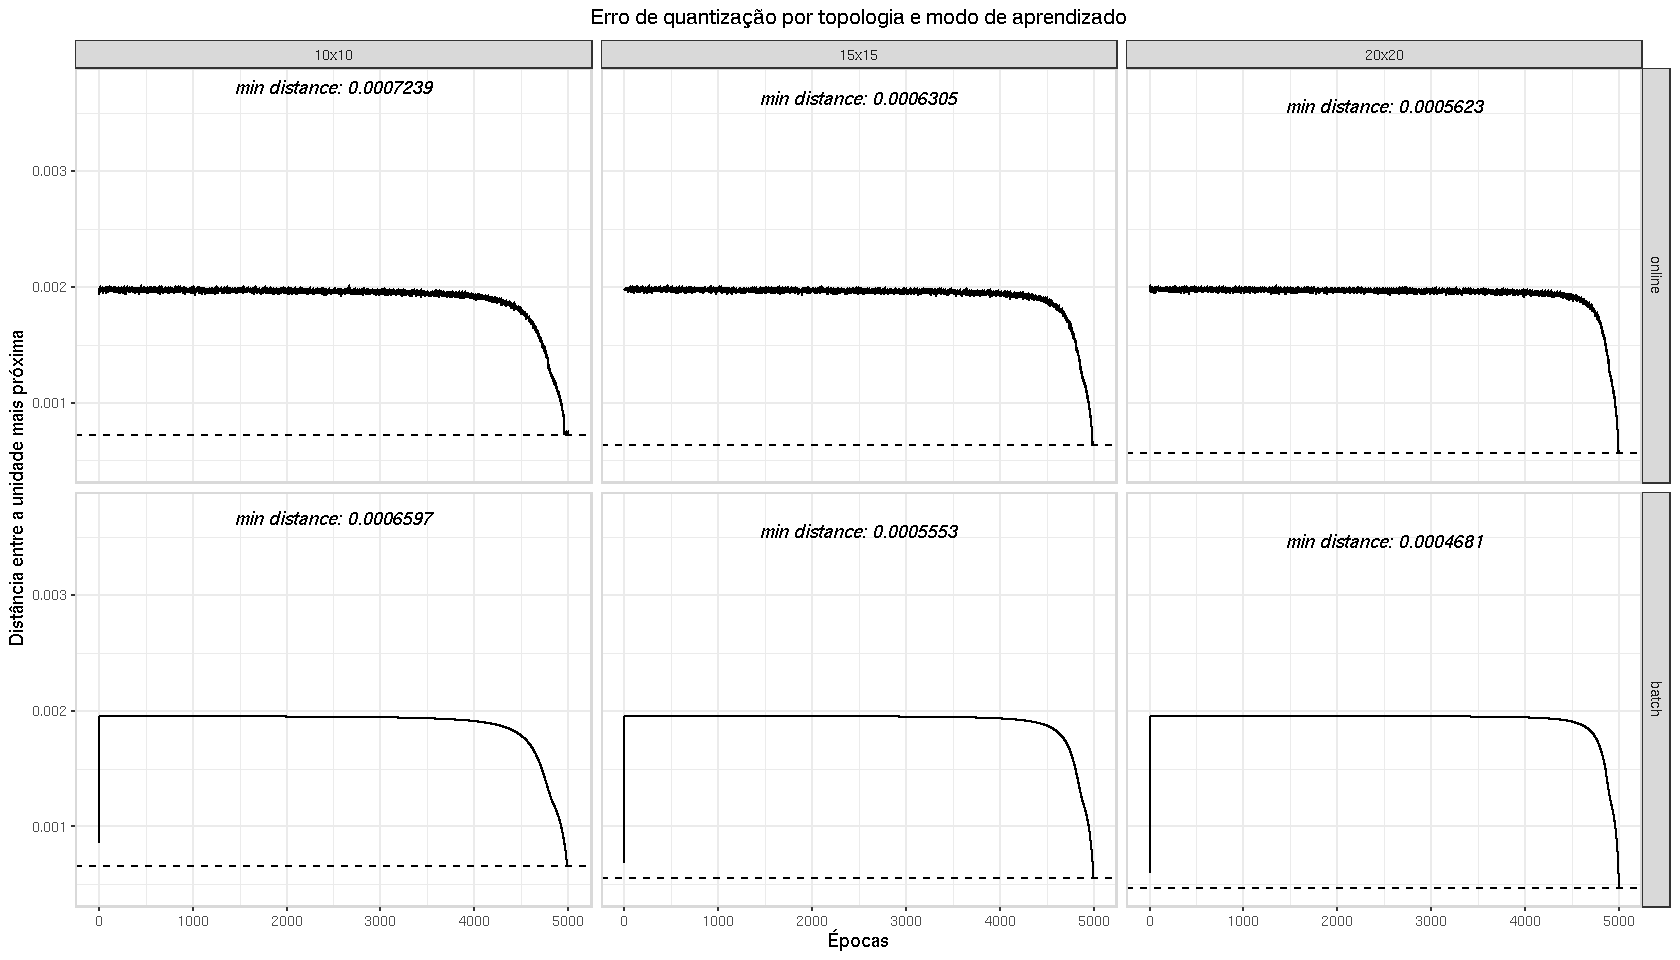

In [178]:
options(repr.plot.width=14, repr.plot.height=8)

# Erro de quantização com as configurações default
quantisation_plot(model_df, levels_grid = c("10x10", "15x15", "20x20"))

In [181]:
ggsave("./som_quantization_error", device = "pdf", width = 13, height = 7)

- #### U-matrix

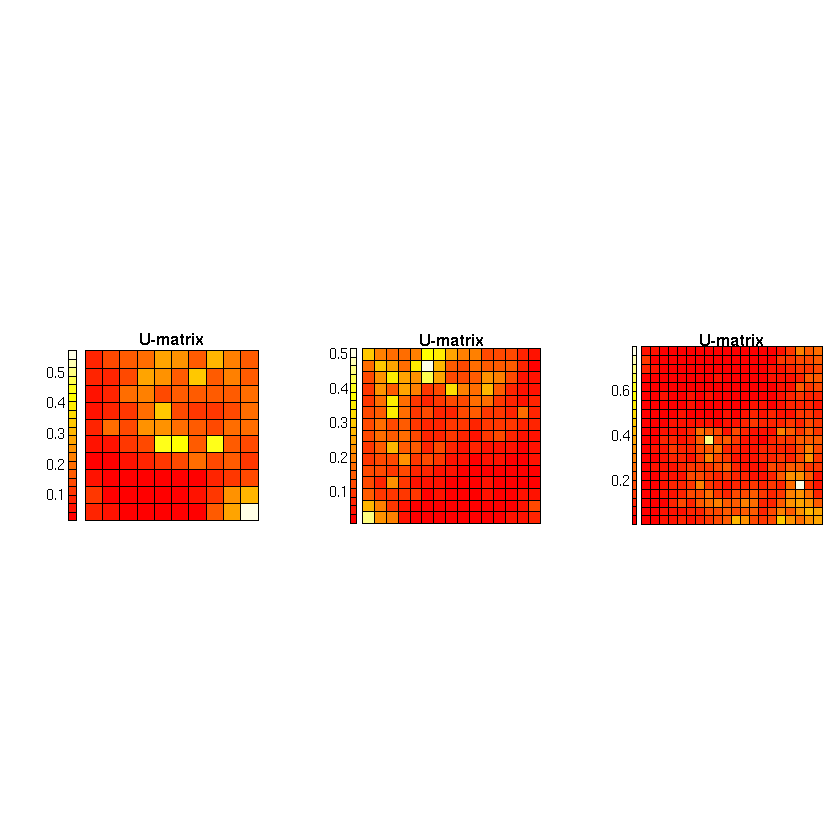

In [129]:
options(repr.plot.width=7, repr.plot.height=7)
par(mfcol=c(1,3)) 

list_som_models <- list(model_som_batch_10_10, model_som_batch_15_15, model_som_batch_20_20)

umatrix_plot(list_som_models, title = "U-matrix")

#### Hitmap

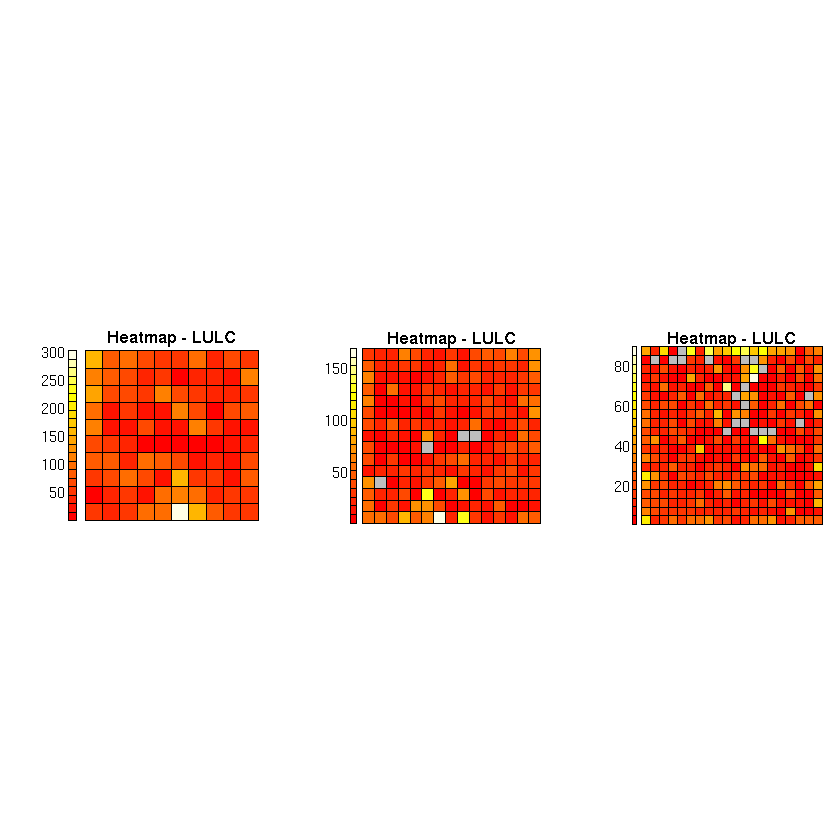

In [130]:
# Criação da lista de modelos SOM
list_som_models <- list(model_som_batch_10_10, model_som_batch_15_15, model_som_batch_20_20)


hitmap_plot(list_som_models, title = "Heatmap - LULC")

#### Heatmap


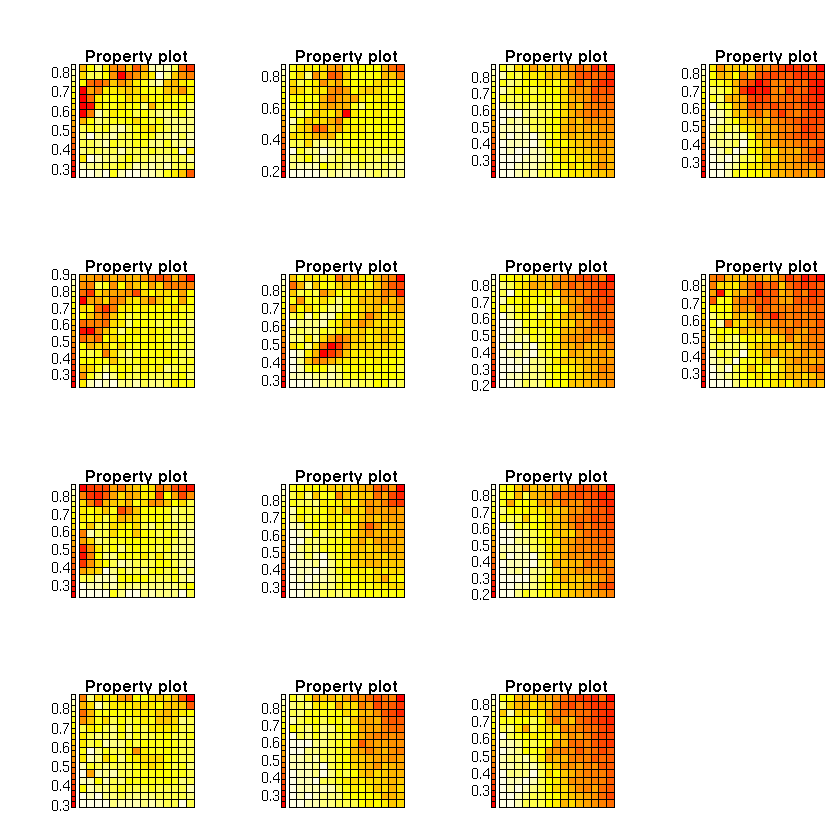

In [100]:
heatmap_plot(model_som_batch_15_15, grid_col = c(4,4))

####  Ferramenta *ggsom*

In [172]:
ggsom_20_20 <- ggsom_aes(model_som_batch_20_20, dados_wide[2])
ggsom_20_20 <- as_tibble(ggsom_20_20)

ggsom_gathered_20_20 <- ggsom_20_20 %>% gather(atributo,
                                           valores,
                                           -unit.class,
                                           -reference,
                                           -id,
                                           -x,
                                           -y,
                                           -sum)

datas <- tibble::tibble(dias = timeseries_forest_select$time_series[[1]]$Index,
                atributo = c(paste0("V",1:14)) )

teste_20_20 <- ggsom_gathered_20_20 %>% dplyr::left_join(datas, by="atributo")
ggsom_data_20_20_entropy <- get_entropy(teste_20_20)

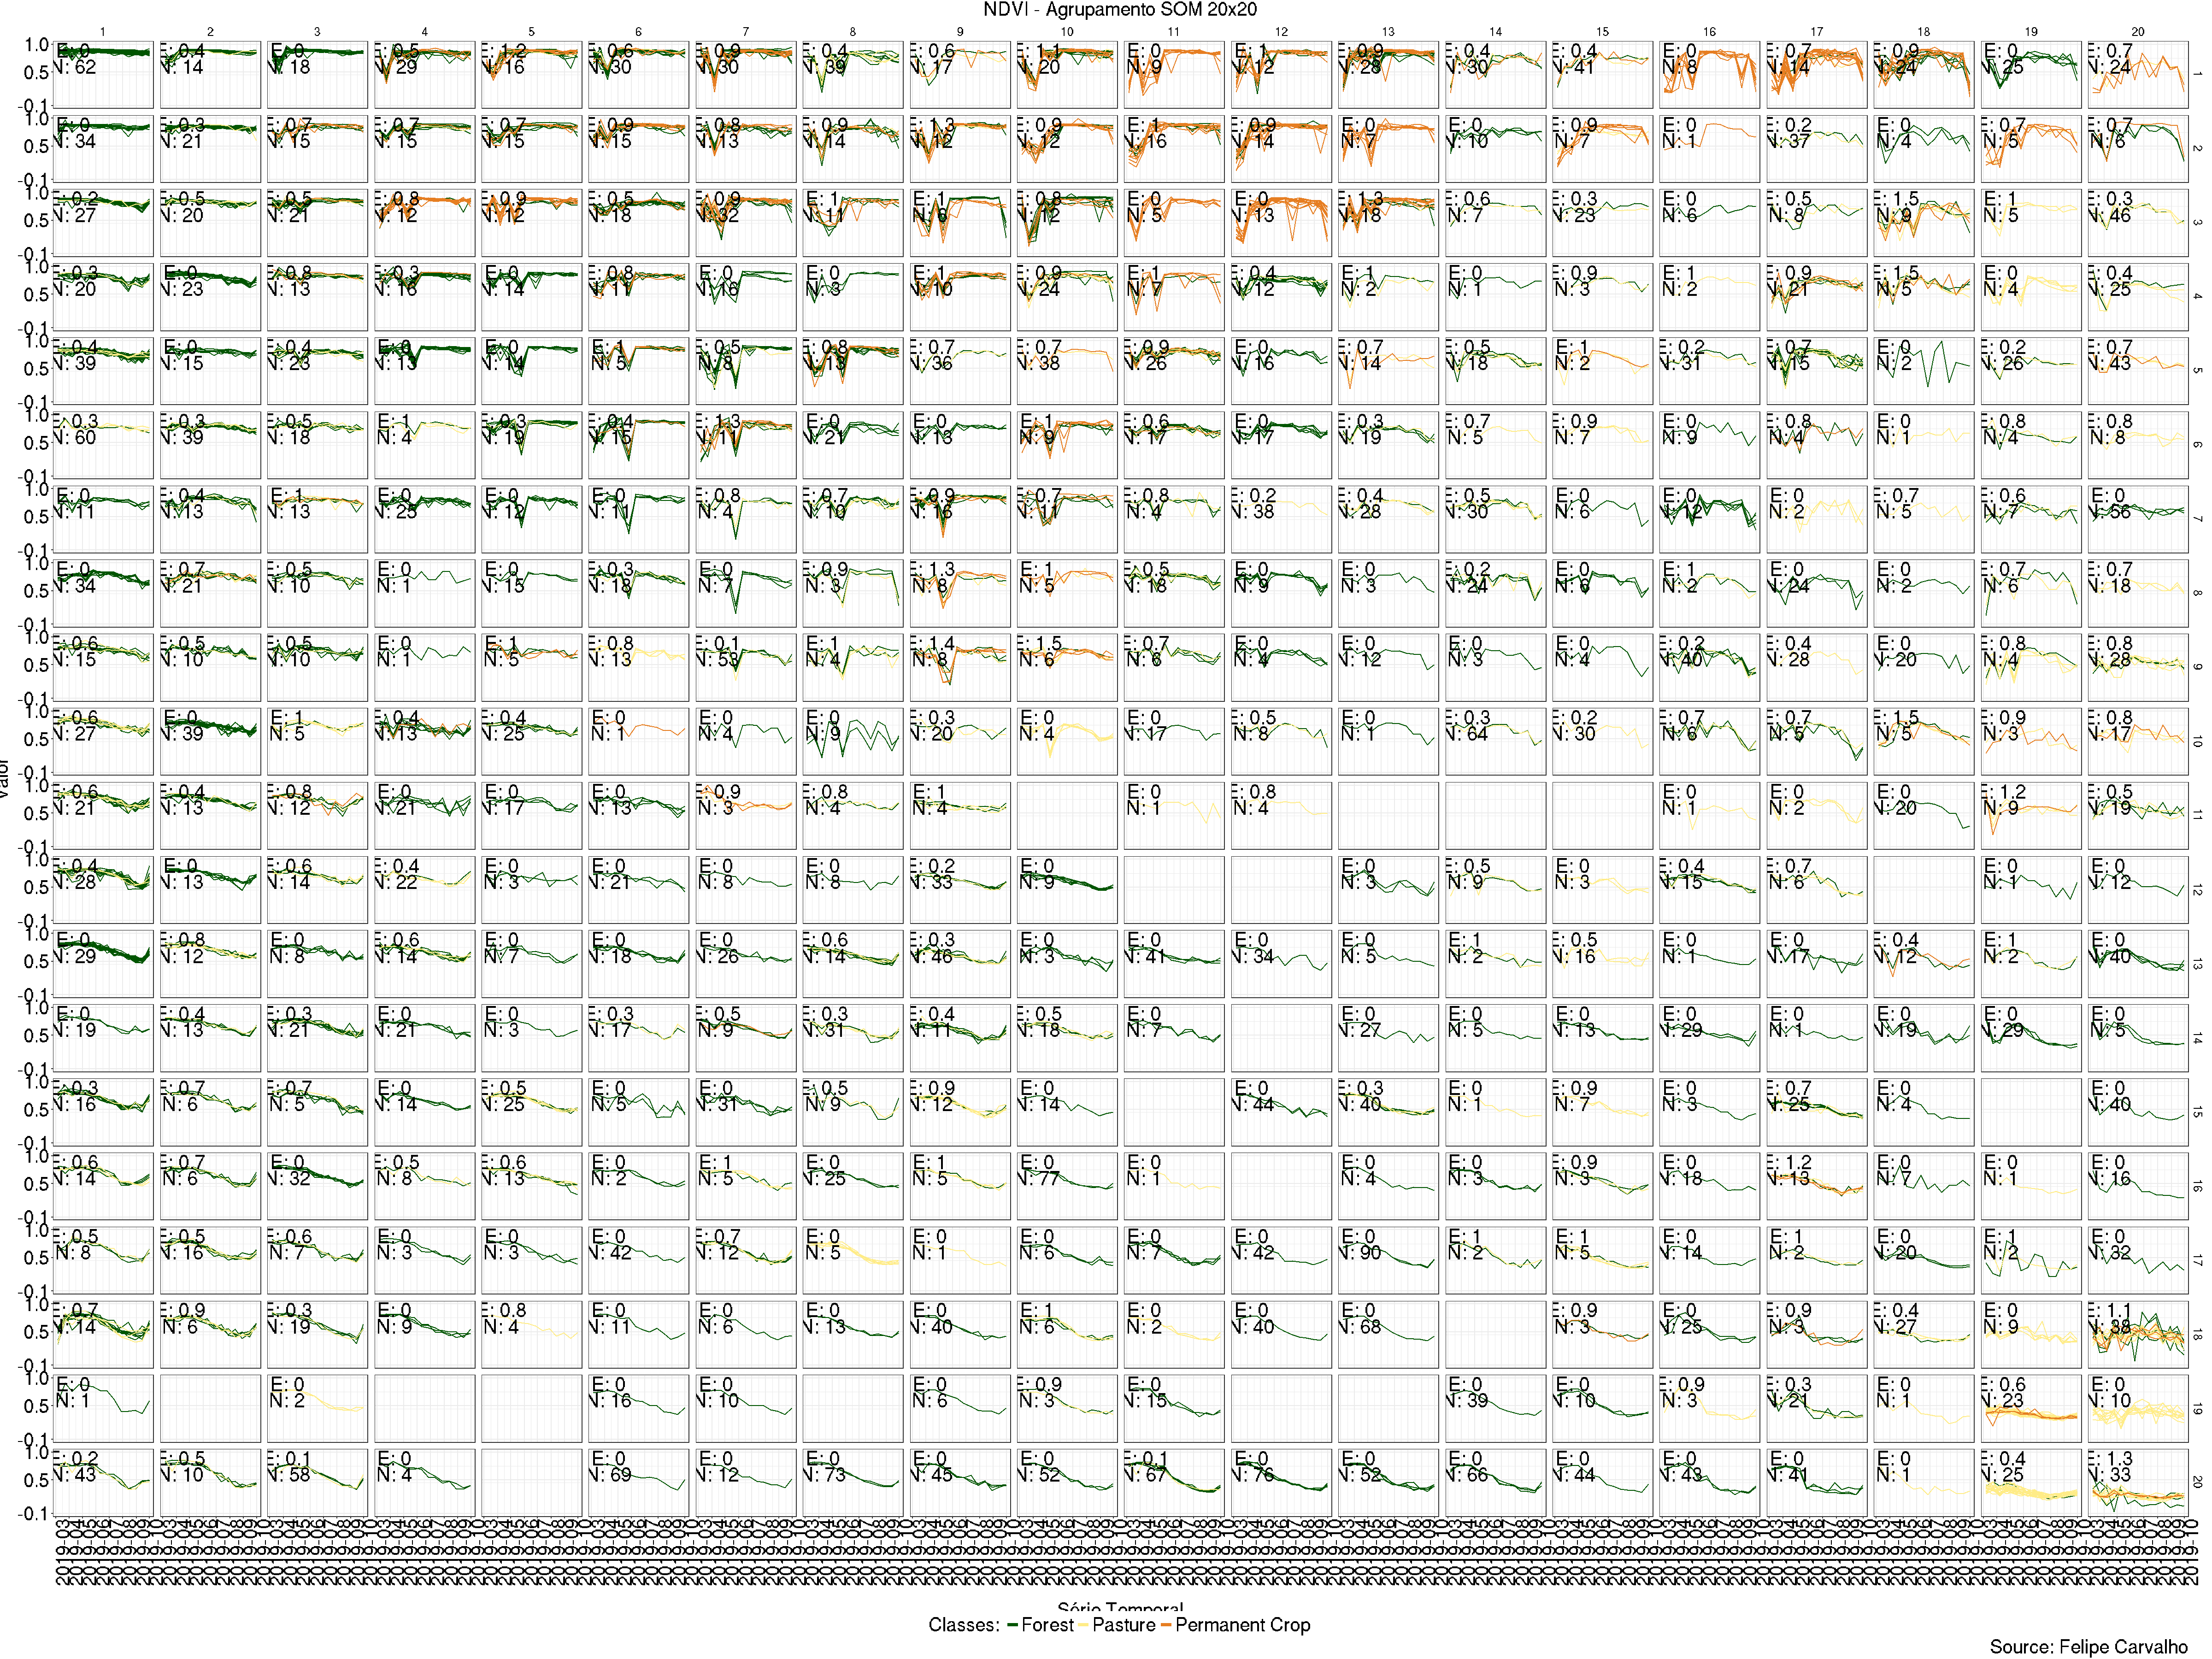

In [182]:
options(repr.plot.width=40, repr.plot.height=30)

ggplot2::ggplot(ggsom_data_20_20_entropy, aes(x = dias, y = valores, group = id, color=reference)) +
  geom_line(size=0.55) +
  labs(
    title = "NDVI - Agrupamento SOM 20x20",
    caption = "Source: Felipe Carvalho",
    y = "Valor",
    x = "Série Temporal"
  ) +
  facet_grid(y ~ x, labeller=label_parsed, scales = "free") +
  scale_y_continuous(limits = c(-0.1,1),
                     breaks=c(-0.1, 1, 0.5)) +
  scale_x_date(labels = date_format("%Y-%m"),
               breaks='1 month',
               limits = as.Date(c("2019-03-06", "2019-09-30"))) +
  theme(
    strip.text.x = element_text(size = 16, colour = "black"),
    strip.text.y = element_text(size = 16, colour = "black"),
    plot.title = element_text(size = 25,
                              hjust= 0.5,
                              margin = margin(b = 7)),
    strip.background = element_blank(),
    panel.spacing = unit(0.6, "lines"),
    axis.text.x = element_text(angle = 90,
                               color = "black",
                               size  = 25,
                               margin = margin(t = 0, r = -10, b = 0, l = 0)),
    axis.text.y = element_text(size = 25, color="black"),
    axis.title.x = element_text(margin = margin(t = 7),
                                size=25,
                                vjust=-3),
    axis.title.y = element_text(size = 25, vjust=3),
    legend.position="bottom",
    legend.key.size = unit(1.2, "lines"),
    legend.spacing = unit(0.1, "cm"),
    legend.text = element_text(size = 25),
    legend.title = element_text(size = 25),
    plot.caption = element_text(size = 25, color="black"),
    legend.spacing.x = unit(0.10, 'cm'))+
  guides(colour = guide_legend(nrow = 1, override.aes = list(size = 2)),
         label.hjust = 10,
         fill=guide_legend(
           keywidth=4,
           keyheight=1))+
    scale_color_manual(name = "Classes: ",
                     labels = c("Forest",
                                "Pasture",
                                "Permanent Crop"),
                     values = c("#005500",
                                "#ffec87",
                                "#e67e22")) +
    geom_text(aes(
    y = 0.60,
    x = as.Date("2019-04-10", "%Y-%m-%d"),
    label = paste("N:", sum)), check_overlap = TRUE,
    show.legend = FALSE,
    colour="black",
    size = 9) +
  geom_text(aes(
    y = 0.89,
    x = as.Date("2019-04-10", "%Y-%m-%d"),
    label = paste("E:",round(entropy, 1))), check_overlap = TRUE,
    show.legend = FALSE,
    colour="black",
    size = 9)

In [184]:
ggsave("./som_ggsom", device = "pdf", width = 40, height = 30)

### Uso da biblioteca SITS

#### Seleção do NDVI

In [277]:
select_ndvi <- purrr::map(timeseries_forest_select$time_series, function(x){
    x %>% dplyr::select(-evi)
})

timeseries_forest_teste <- timeseries_forest_select %>% 
                            dplyr::select(-time_series) 

timeseries_forest_teste <- tibble::add_column(timeseries_forest_teste, time_series = select_ndvi)

#### Criação da rede SOM 

In [287]:
som_cluster <-
sits::sits_som_map(data =timeseries_forest_teste,
                   grid_xdim = 20,
                   grid_ydim = 20,
                   alpha = 0.05,
                   distance = "euclidean",
                   iterations = 10)

#### Codes plot

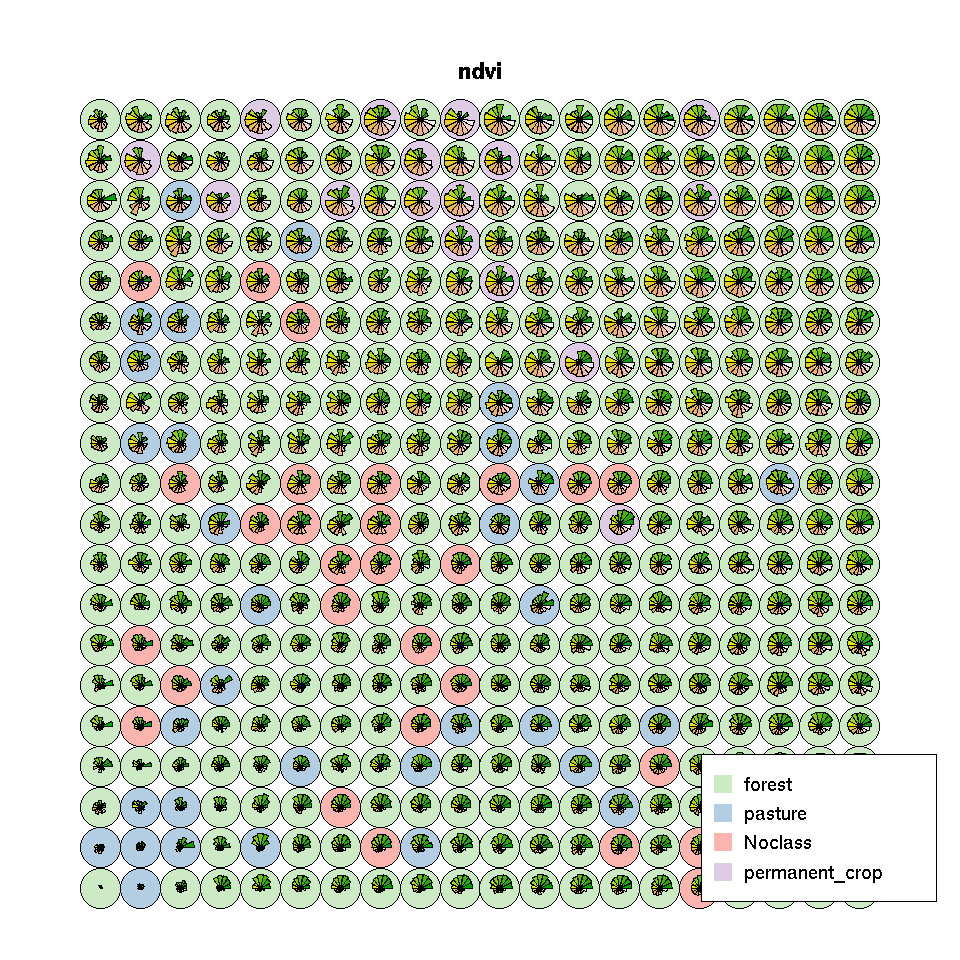

In [335]:
options(repr.plot.width=8, repr.plot.height=8)
plot(som_cluster, type="codes")

In [336]:
ggsave("./codes_plot_sits", device = "jpg", width = 13, height = 7)

#### Informações sobre as mistura entre as classes

In [303]:
cluster_overall$mixture_cluster

id_class,cluster,original_class,mixture_percentage
1,forest,forest,92.459724
1,forest,pasture,4.816476
1,forest,permanent_crop,2.723800
2,pasture,pasture,83.783784
2,pasture,forest,9.459459
2,pasture,permanent_crop,6.756757
3,permanent_crop,permanent_crop,75.301205
3,permanent_crop,forest,22.891566
3,permanent_crop,pasture,1.807229


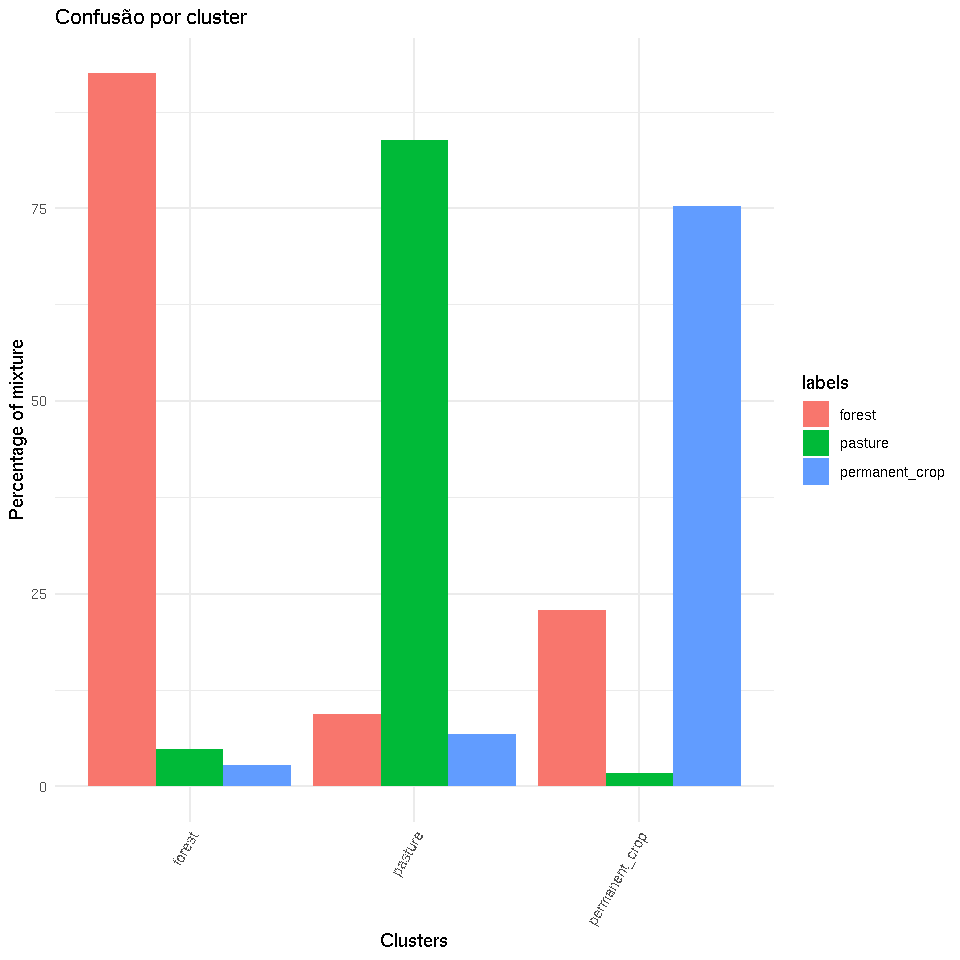

In [294]:
sits::sits_som_plot_clusters(cluster_overall, "Confusão por cluster")

In [302]:
ggsave("./percent_misture", device = "jpg", width = 13, height = 7)

#### Matriz de confusão

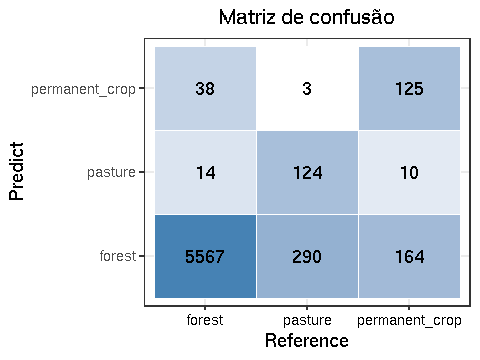

In [330]:
library(scales)

ggplotConfusionMatrix <- function(m){
  mytitle <- paste("Accuracy", percent_format()(m$overall[1]))
  p <-
    ggplot(data = as.data.frame(m$table) ,
           aes(x = Var1, y = Var2)) +
    geom_tile(aes(fill = log(Freq)), colour = "white") +
    scale_fill_gradient(low = "white", high = "steelblue") +
    geom_text(aes(x = Var1, y = Var2, label = Freq)) +
    theme(legend.position = "none") +
    #ggtitle(mytitle) +
    labs(x = "Reference",
        y = "Predict",
        title= "Matriz de confusão") + 
    theme(
        axis.text.x = element_text(angle = 0,
                               color = "black"),
          plot.title = element_text(hjust= 0.5))
  return(p)
}

options(repr.plot.width=4, repr.plot.height=3)
ggplotConfusionMatrix(cluster_overall$confusion_matrix)

In [334]:
ggsave("./confusion_matrix", device = "pdf", width = 5, height = 3)

In [310]:
cluster_overall$confusion_matrix

Confusion Matrix and Statistics

                
                 forest pasture permanent_crop
  forest           5567      14             38
  pasture           290     124              3
  permanent_crop    164      10            125

Overall Statistics
                                         
               Accuracy : 0.9181         
                 95% CI : (0.911, 0.9247)
    No Information Rate : 0.9504         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.4687         
                                         
 Mcnemar's Test P-Value : <2e-16         

Statistics by Class:

                     Class: forest Class: pasture Class: permanent_crop
Sensitivity                 0.9246        0.83784               0.75301
Specificity                 0.8344        0.95264               0.97179
Pos Pred Value              0.9907        0.29736               0.41806
Neg Pred Value              0.3659        0.99594    